# Modelling and Evaluation Notebook

## Objectives

*   Answer business requirement 2: 
    * The client is interested in predicting if a cherry leaf is healthy or contains powdery mildew.


## Inputs

* inputs/mildew_dataset/cherry-leaves/train
* inputs/mildew_dataset/cherry-leaves/test
* inputs/mildew_dataset/cherry-leaves/validation
* image shape embeddings.

## Outputs
* Plot showing distribution of images in train, validation, and test sets.
* Applied image augmentation
* Mapping of class indices for label prediction inference
* Creation and training of machine learning model.
* Saving the trained model.
* Plotting learning curve to visualize model performance..
* Evaluating model performance using a pickle file..
* Making predictions on a randomly chosen image file.




## Additional Comments | Insights | Conclusions

---

---

# Import regular packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

---

# Set Working Directory

In [2]:
cwd= os.getcwd()

In [3]:
os.chdir('/workspace/pp5-mildew-detection')
print("You set a new current directory")

You set a new current directory


In [4]:
work_dir = os.getcwd()
work_dir

'/workspace/pp5-mildew-detection'

---

## Set input directories

Set train, validation and test paths

In [5]:
my_data_dir = 'inputs/mildew_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set output directory

In [6]:
version = 'v2'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('A prior version is in place; proceed with making a new version.')
    pass
else:
    os.makedirs(name=file_path)


A prior version is in place; proceed with making a new version.


## Set labels

In [7]:
labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
)

Project Labels: ['healthy', 'powdery_mildew']


## Set image shape

In [8]:
import joblib

version = 'v2'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

# Count of Images in Train, Test, and Validation Datasets

* train - healthy: 736 images
* train - powdery_mildew: 736 images
* validation - healthy: 105 images
* validation - powdery_mildew: 105 images
* test - healthy: 211 images
* test - powdery_mildew: 211 images




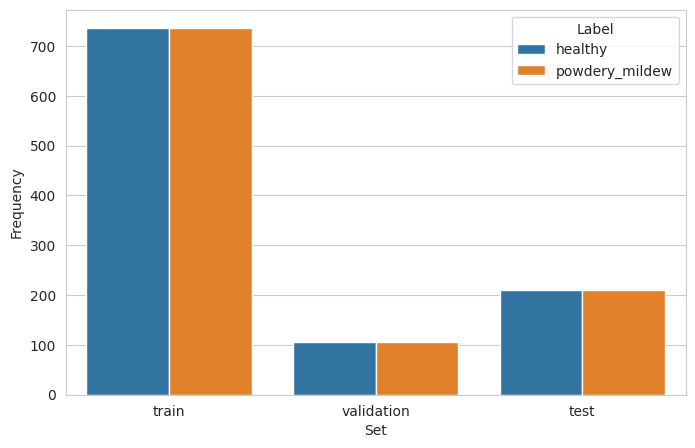

In [9]:
df_freq = pd.DataFrame([])
for folder in ['train', 'validation', 'test']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )
        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")
print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

---

# Image data augmentation

---

### ImageDataGenerator

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Initialize ImageDataGenerator

In [11]:
enhanced_img_data = ImageDataGenerator(rotation_range=20,
                                       width_shift_range=0.10,
                                       height_shift_range=0.10,
                                       shear_range=0.1,
                                       zoom_range=0.1,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='nearest',
                                       rescale=1./255
                                       )

* ### Augment training image dataset

In [12]:
batch_size = 1
train_set = enhanced_img_data.flow_from_directory(train_path,
                                                  target_size=image_shape[:2],
                                                  color_mode='rgb',
                                                  batch_size=batch_size,
                                                  class_mode='binary',
                                                  shuffle=True
                                                  )

train_set.class_indices

Found 1472 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

* ### Augment validation image dataset

In [13]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 210 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

* ### Augment test image dataset

In [14]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices


Found 422 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

## Plot augmented training image

(1, 256, 256, 3)


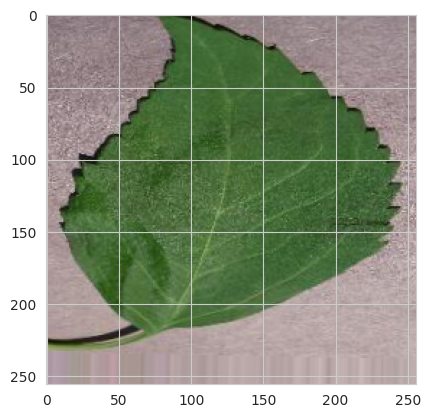

(1, 256, 256, 3)


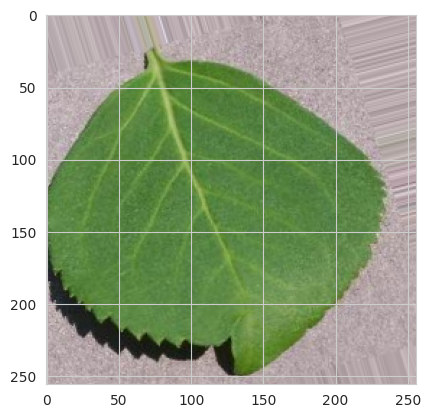

(1, 256, 256, 3)


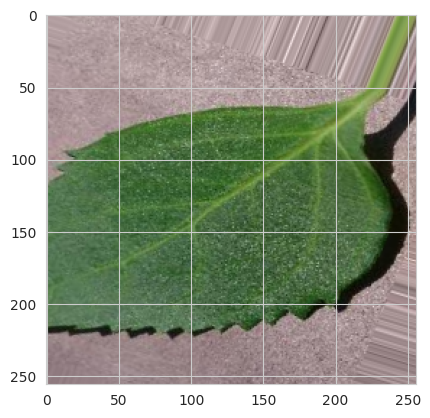

In [15]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape) 
    plt.imshow(img[0])
    plt.show()

## Plot augmented validation and test images

(1, 256, 256, 3)


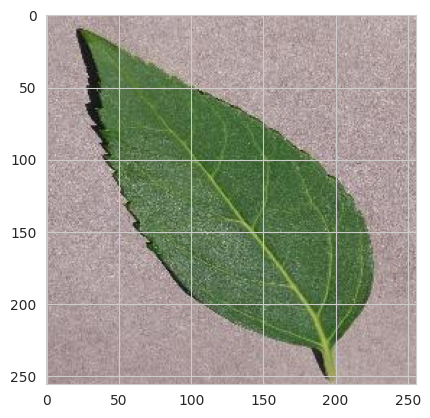

(1, 256, 256, 3)


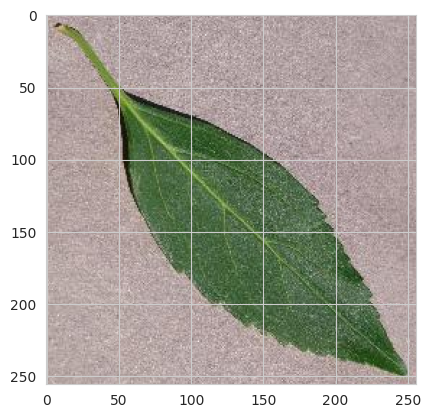

(1, 256, 256, 3)


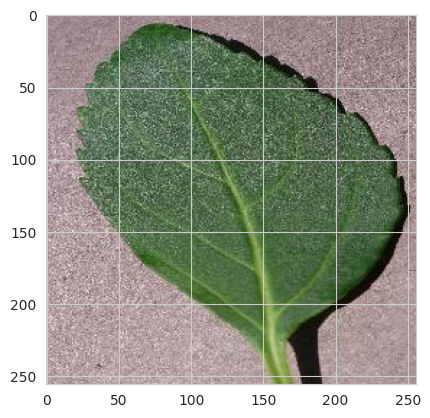

In [16]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape) 
    plt.imshow(img[0])
    plt.show()

(1, 256, 256, 3)


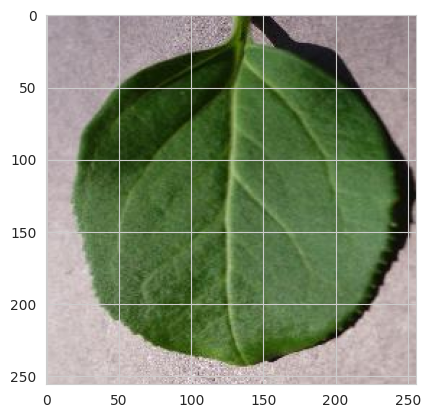

(1, 256, 256, 3)


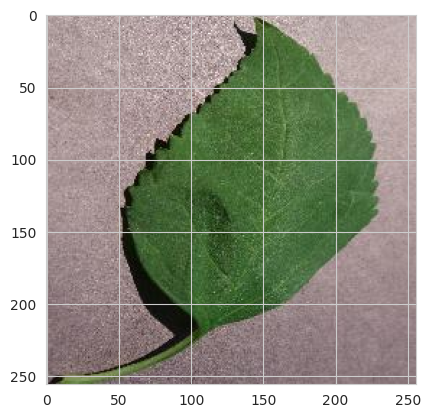

(1, 256, 256, 3)


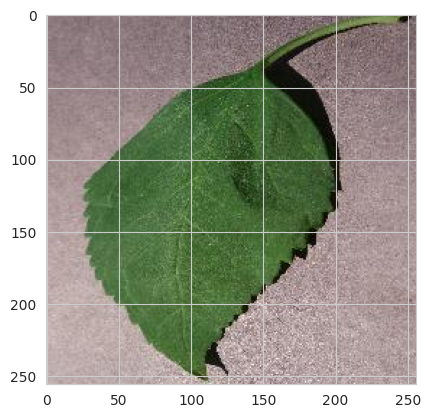

In [17]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

## Save class_indices

In [18]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v2/class_indices.pkl']

---

# Model creation

---

* ### Import model packages

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

* ### Model 

In [20]:
def tf_model():
    model = Sequential()

    model.add(Conv2D(filters=16, kernel_size=(3, 3), input_shape=image_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model
    
    # model.compile(loss='binary_crossentropy',
    #               optimizer='rmsprop',
    #               metrics=['accuracy'])

* ### Model Summary 

In [21]:
tf_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       7

2024-07-14 13:32:40.977147: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


* ### Patience value (Early Stopping) 

In [22]:
from tensorflow.keras.callbacks import EarlyStopping
stop_training = EarlyStopping(monitor='val_loss', patience=4)

## Fit model for model training

In [23]:
model = tf_model()
history = model.fit(
    train_set,
    epochs=25,
    steps_per_epoch=len(train_set.classes),
    validation_data=validation_set,
    callbacks=[stop_training],
    verbose=1
)

Epoch 1/25


2024-07-14 13:32:41.226061: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


1472/1472 [==============================] - 143s 97ms/step - loss: 0.5843 - accuracy: 0.7113 - val_loss: 0.3231 - val_accuracy: 0.8429
Epoch 2/25
1472/1472 [==============================] - 141s 96ms/step - loss: 0.2349 - accuracy: 0.9117 - val_loss: 0.1720 - val_accuracy: 0.9381
Epoch 3/25
1472/1472 [==============================] - 142s 96ms/step - loss: 0.2338 - accuracy: 0.9117 - val_loss: 0.1196 - val_accuracy: 0.9619
Epoch 4/25
1472/1472 [==============================] - 141s 96ms/step - loss: 0.1821 - accuracy: 0.9409 - val_loss: 0.0930 - val_accuracy: 0.9619
Epoch 5/25
1472/1472 [==============================] - 142s 97ms/step - loss: 0.2183 - accuracy: 0.9137 - val_loss: 0.4357 - val_accuracy: 0.8667
Epoch 6/25
1472/1472 [==============================] - 142s 97ms/step - loss: 0.1992 - accuracy: 0.9484 - val_loss: 0.0886 - val_accuracy: 0.9810
Epoch 7/25
1472/1472 [==============================] - 141s 96ms/step - loss: 0.1696 - accuracy: 0.9565 - val_loss: 0.0415 - val

## Save model

In [24]:
model.save('outputs/v2/trained_model.h5')

---

# Model Performace

---

## Model learning curve

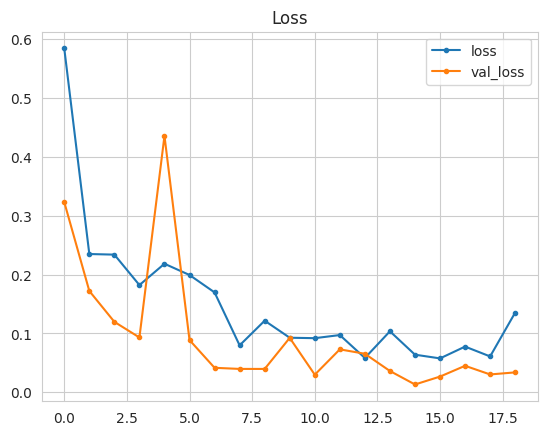

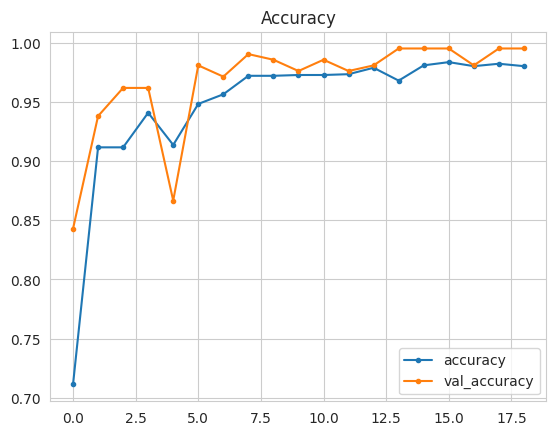

In [25]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()


## Model Evaluation

Load saved model

In [26]:
from keras.models import load_model
model = load_model('/workspace/pp5-mildew-detection/outputs/v2/trained_model.h5')

Evaluate model on test set

In [27]:
evaluation = model.evaluate(test_set)

422/422 [==============================] - 9s 21ms/step - loss: 0.0291 - accuracy: 0.9976


### Save evaluation pickle

In [28]:
joblib.dump(value=evaluation,
            filename=f"outputs/v2/evaluation.pkl")


['outputs/v2/evaluation.pkl']

## Predict on new data

Load a random image as PIL

Image shape: (256, 256), Image mode: RGB


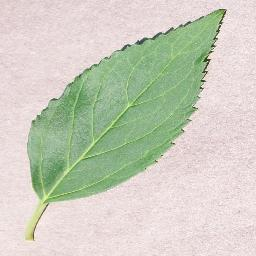

In [29]:
from tensorflow.keras.preprocessing import image

pointer = 66
label = labels[0]  # select Uninfected or Parasitised

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

Convert image to array and prepare for prediction

In [30]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 256, 256, 3)


Predict class probabilities

In [31]:
pred_probability = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_probability > 0.5]

if pred_class == target_map[0]:
    pred_probability = 1 - pred_probability

print(pred_probability)
print(pred_class)

0.9697917401790619
healthy


---

# Push files to Repo

## Push generated/new files from this Session to your GitHub repo

* .gitignore

In [32]:
!cat .gitignore

core.Microsoft*
core.mongo*
core.python*
env.py
__pycache__/
*.py[cod]
node_modules/
.github/
cloudinary_python.txt
kaggle.json

In [33]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add/rm <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	deleted:    inputs/mildew_dataset/cherry-leaves/test/healthy/0008f3d3-2f85-4973-be9a-1b520b8b59fc___JR_HL 4092_flipTB.JPG
	deleted:    inputs/mildew_dataset/cherry-leaves/test/healthy/002efba9-09b3-43de-93b7-5c2460185cde___JR_HL 9655.JPG
	deleted:    inputs/mildew_dataset/cherry-leaves/test/healthy/0580bdc7-e60e-4ba9-87dc-1202e57b94aa___JR_HL 4159_flipTB.JPG
	deleted:    inputs/mildew_dataset/cherry-leaves/test/healthy/085e9f8b-9574-4b6f-a8e9-309a35c94b25___JR_HL 9755.JPG
	deleted:    inputs/mildew_dataset/cherry-leaves/test/healthy/0a1319ef-0cbb-4fcc-8126-9c18813f3bac___JR_HL 4012.JPG
	deleted:    inputs/mildew_dataset/cherry-leaves/test/healthy/0de1122b-b2f0-4ae4-bd30-1893331a9ea1___JR_HL 9681.JPG
	deleted:    inputs/mildew_dataset/cherry-leaves/test/healthy

* Git add

In [34]:
!git add .

* Git commit

In [ ]:
!git commit -am " Add new plots"

* Git Push

In [ ]:
!git push

---